### Classifier

In [13]:
# imports
import os
import numpy as np
# import instruments
import preprocess
import numpy as np
import csv
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split


from scipy.io.wavfile import read as read_wav
from scipy.io.wavfile import write as write_wav
import matplotlib.pyplot as plt


In [14]:
# for hardware optimization
# print(torch.cuda.is_available())
# cuda_id = torch.cuda.current_device()
# print(cuda_id)
# print(torch.cuda.get_device_name(cuda_id))

In [15]:
# Set up paths to audio data
base_dir = os.path.dirname(os.getcwd())
data_mini = np.load(f"{base_dir}/data/mini/note_samples/notes_padded.npy")
labels_mini = pd.read_csv(f"{base_dir}/data/mini/note_labels/labels_centered.csv").to_numpy()
assert np.shape(data_mini) == (10000, 8000)
assert np.shape(labels_mini) == (10000, 9)

In [16]:
# normalize notes to 1-12

key_notes = {
    # 'B': 59,
    60: 'C'
    # 'C#': 61,
    # 'Db': 61,
    # 'D': 62,
    # # 'D#': 63,
    # 'Eb': 63,
    # 'E': 64,
    # 'F': 65,
    # # 'F#': 66,
    # 'Gb': 66,
    # 'G': 67,
    # # 'G#': 68,
    # 'Ab': 68,
    # 'A': 69,
    # # 'A#': 70,
    # 'Bb': 70,
    # 'B': 71
}
order = ['C', 'B', 'Bb', 'A', 'Ab', 'G', 'Gb', 'F', 'E', 'Eb', 'D', 'Db']

new_notes = {
    'C': 1, 
    'Db': 2,
    'D': 3,
    'Eb': 4,
    'E': 5,
    'F': 6,
    'Gb': 7,
    'G': 8,
    'Ab': 9,
    'A': 10,
    'Bb': 11, 
    'B': 12
}

counter = 1
i = 59
while i >= 29:
    if i not in key_notes.values():
        key_notes[i] = order[counter]
        counter += 1
        if counter >= len(order): counter = 0
    i -= 1
    # print(i)
i = 61
counter = len(order) - 1
while i <= 98:
    if i not in key_notes.values():
        key_notes[i] = order[counter]
        counter -= 1
        if counter <= 0: counter = len(order) - 1
    i += 1
print(key_notes)



for i in range(len(labels_mini)):
    labels_mini[i][5] = new_notes[key_notes[labels_mini[i][5]]]


{60: 'C', 59: 'B', 58: 'Bb', 57: 'A', 56: 'Ab', 55: 'G', 54: 'Gb', 53: 'F', 52: 'E', 51: 'Eb', 50: 'D', 49: 'Db', 48: 'C', 47: 'B', 46: 'Bb', 45: 'A', 44: 'Ab', 43: 'G', 42: 'Gb', 41: 'F', 40: 'E', 39: 'Eb', 38: 'D', 37: 'Db', 36: 'C', 35: 'B', 34: 'Bb', 33: 'A', 32: 'Ab', 31: 'G', 30: 'Gb', 29: 'F', 61: 'Db', 62: 'D', 63: 'Eb', 64: 'E', 65: 'F', 66: 'Gb', 67: 'G', 68: 'Ab', 69: 'A', 70: 'Bb', 71: 'B', 72: 'Db', 73: 'D', 74: 'Eb', 75: 'E', 76: 'F', 77: 'Gb', 78: 'G', 79: 'Ab', 80: 'A', 81: 'Bb', 82: 'B', 83: 'Db', 84: 'D', 85: 'Eb', 86: 'E', 87: 'F', 88: 'Gb', 89: 'G', 90: 'Ab', 91: 'A', 92: 'Bb', 93: 'B', 94: 'Db', 95: 'D', 96: 'Eb', 97: 'E', 98: 'F'}


In [17]:
# only train on instrument 1: Acoustic Grand Piano
indices_to_remove = [i for i in range(len(labels_mini)) if labels_mini[i][4] != 1]

labels_mini = [labels_mini[i] for i in range(len(labels_mini)) if i not in indices_to_remove]
data_mini = data_mini[~np.isin(np.arange(len(data_mini)), indices_to_remove)]




In [18]:
data = np.array(labels_mini)

minimum = np.min(data[:, 5])
maximum = np.max(data[:, 5])

print("min: ", minimum)
print("max: ", maximum)
print(len(labels_mini))
print(len(data_mini))

min:  1
max:  12
3200
3200


In [19]:
hyperparameters = {
    'n_epochs': 1000,
    'learning_rate': 0.001,
    'dropout_rate': 0.7,
    'filters': [32, 64, 128, 256]
}

Spectograms

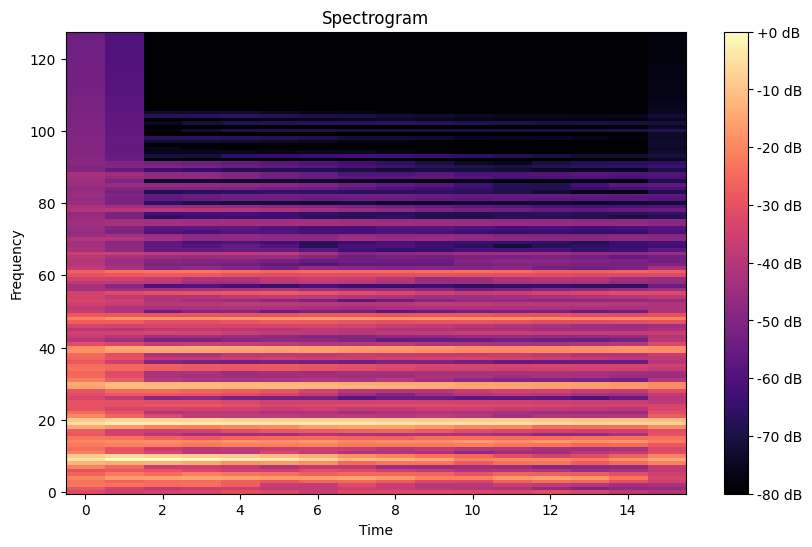

In [20]:
# Compute basic spectrograms for note
def get_spect(note, n_fft, hop_length, sr):
    stft = np.abs(librosa.stft(note, n_fft=n_fft, hop_length=hop_length))
    mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    return log_mel

spectrogram = get_spect(data_mini[0], n_fft=2048, hop_length=512, sr=22050)
# print(spectrogram)

# Plotting the spectrogram for one note
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.show()


In [22]:
spectograms = []
for note in data_mini:
    spectograms.append(get_spect(note, n_fft=2048, hop_length=512, sr=22050))
spectnp = np.array(spectograms)
from numpy import asarray
from numpy import savetxt
# savetxt('../exhibition/data.csv', asarray(spectnp), delimiter=',')
print(spectnp.shape)

(3200, 128, 16)


In [23]:
resh_spectnp = spectnp.reshape(3200, 1, 128, 16)
print(resh_spectnp.shape)
# print(labels_mini.shape)

# remove note timing string from labels for spectral training

# labels_list = labels_mini.tolist()

# # Remove the last element from each array
# labels_list = [arr[:-1] for arr in labels_list]

# # Convert the list back to a numpy array
# labels_mini = np.array(labels_list)

# Extract all but the last element from each array
labels_mini_note = np.array([arr[5] for arr in labels_mini])
# print(labels_mini_note[0])


(3200, 1, 128, 16)


In [24]:
# transform to tensor
spect_data_tensor = torch.from_numpy(resh_spectnp[0:1000]).float()
spect_labels_tensor = torch.from_numpy(labels_mini_note[0:1000]).float()
print(spect_data_tensor.shape)
print(spect_labels_tensor.shape)


mnistspec = train_test_split(spect_data_tensor, spect_labels_tensor, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = mnistspec
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)


torch.Size([1000, 1, 128, 16])
torch.Size([1000])
X_train:  torch.Size([800, 1, 128, 16])
y_train:  torch.Size([800])
X_test:  torch.Size([200, 1, 128, 16])
y_test:  torch.Size([200])


In [25]:
class PitchClassifier(nn.Module):
    def __init__(self, num_filters):
        super(PitchClassifier, self).__init__()
        self.num_filters = num_filters
        self.conv1 = nn.Conv2d(1, num_filters[0], kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(num_filters[1], num_filters[2], kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_filters[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(num_filters[2], num_filters[3], kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(num_filters[3])
        self.fc1 = nn.Linear(num_filters[3] * 8 * 4, 512)  # Update input size based on spectrogram shape
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = x.view(-1, self.num_filters[3] * 8 * 4)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# class PitchClassifier(nn.Module):
#     def __init__(self, num_filters):
#         super(PitchClassifier, self).__init__()
#         self.num_filters = num_filters
#         self.conv1 = nn.Conv2d(1, num_filters[0], kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(num_filters[0])
#         self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(num_filters[1])
#         self.conv3 = nn.Conv2d(num_filters[1], num_filters[2], kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(num_filters[2])
#         self.fc1 = nn.Linear(num_filters[2] * 8 * 4, 512)  # Update input size based on spectrogram shape
#         self.fc2 = nn.Linear(512, 128)
#         self.fc3 = nn.Linear(128, 1)
#         self.relu = nn.LeakyReLU() # nn.ReLU()
#         self.dropout = nn.Dropout(p=0.5)
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.relu(x)
#         x = x.view(-1, self.num_filters[2] * 8 * 4)  # Update input size based on spectrogram shape
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc3(x)
#         return x



# class PitchClassifier(nn.Module):
#     def __init__(self, num_filters):
#         super(PitchClassifier, self).__init__()
#         self.num_filters = num_filters
#         self.conv1 = nn.Conv2d(1, num_filters[0], kernel_size=3, stride=1, padding=1)
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=3, stride=1, padding=1)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.conv3 = nn.Conv2d(num_filters[1], num_filters[2], kernel_size=3, stride=1, padding=1)
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(num_filters[2] * 8 * 4, 512)  # Update input size based on spectrogram shape
#         self.fc2 = nn.Linear(512, 128)
#         self.fc3 = nn.Linear(128, 1)
#         self.relu = nn.LeakyReLU() # nn.ReLU()
#         self.dropout = nn.Dropout(p=0.5)
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.pool2(x)
#         x = self.conv3(x)
#         x = self.relu(x)
#         x = self.pool3(x)
#         x = x.view(-1, self.num_filters[2] * 8 * 4)  # Update input size based on spectrogram shape
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc3(x)
#         return x


# class PitchClassifier(nn.Module):
#     def __init__(self, num_filters):
#         super(PitchClassifier, self).__init__()
#         self.num_filters = num_filters
#         self.conv1 = nn.Conv2d(1, num_filters[0], kernel_size=3, stride=1, padding=1)
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=3, stride=1, padding=1)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.conv3 = nn.Conv2d(num_filters[1], num_filters[2], kernel_size=3, stride=1, padding=1)
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(num_filters[2] * 4 * 1, 512)
#         self.fc2 = nn.Linear(512, 128)
#         self.fc3 = nn.Linear(128, 1)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p=0.5)
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.pool2(x)
#         x = self.conv3(x)
#         x = self.relu(x)
#         x = self.pool3(x)
#         x = x.view(-1, self.num_filters[2] * 4 * 1)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc3(x)
#         return x
    
# class PitchClassifier(nn.Module):
#     def __init__(self):
#         super(PitchClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(64 * 32 * 4, 128)  # Update input size based on spectrogram shape
#         self.fc2 = nn.Linear(128, 1)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p=0.5)
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.pool2(x)
#         x = x.view(-1, 64 * 32 * 4)  # Update input size based on spectrogram shape
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x


In [26]:
def run_one_epoch(model, optimizer, X, y, train=True):
    if train:
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    output = model(X).squeeze()
    acc = torch.sum(output.round() == y.squeeze()) / y.size(0)
    loss = torch.nn.MSELoss()(output, y)

    if train:
        loss.backward()
        optimizer.step()

    # Detach tells torch to stop tracking a tensor's gradients
    return acc.detach(), loss.detach()

# to include dropout rate
# def run_one_epoch(model, optimizer, X, y, train=True, dropout_rate=0.5):
#     if train:
#         model.train()
#         optimizer.zero_grad()
#     else:
#         model.eval()

#     output = model(X).squeeze()
#     acc = torch.sum(output.round() == y.squeeze()) / y.size(0)
#     loss = torch.nn.MSELoss()(output, y)

#     if train:
#         model.train()  # Ensure dropout is enabled during training
#         for module in model.modules():
#             if isinstance(module, torch.nn.Dropout):
#                 module.p = dropout_rate

#         loss.backward()
#         optimizer.step()

#     # Detach tells torch to stop tracking a tensor's gradients
#     return acc.detach(), loss.detach()


In [27]:
from collections import defaultdict


def demo(model, data, n_epochs=100, lr=0.001, verbose=False):
    X_train, X_test, y_train, y_test = data
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    results = defaultdict(list)
    for i in range(n_epochs):
        train_acc, train_loss = run_one_epoch(model, optimizer, X_train, y_train, train=True)
        test_acc, test_loss = run_one_epoch(model, optimizer, X_test, y_test, train=False)

        results["train_acc"].append(train_acc)
        results["test_acc"].append(test_acc)
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

        if verbose and (i + 1) % (n_epochs // 10) == 0:
            train_stats = f"Train loss: {train_loss:.3f} Train accuracy: {100 * train_acc:4.1f}%"
            test_stats = f"Test loss: {test_loss:.3f} Test accuracy: {100 * test_acc:.1f}%"
            print(f"{i + 1:4d} {train_stats} {test_stats}")

    return results

In [28]:
def print_model(model):
    """ 
    A simple functon that prints out a PyTorch model's structural details
    """
    # Print the number of parameters in the model
    parameter_count =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("In total, this network has ", parameter_count, " parameters")

In [29]:
def plot(results):    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
                             constrained_layout=True)

    ax = axes[0]
    ax.set_title("Loss per Epoch")
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    n_epochs = len(train_loss)
    ax.plot(np.arange(n_epochs), train_loss, c='r', label='Train Loss')
    ax.plot(np.arange(n_epochs), test_loss, c='b', label='Test Loss')
    ax.legend(loc="best")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, 2 * ymax)

    # Bottom right
    ax = axes[1]
    ax.set_title("Accuracy per Epoch")
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]
    n_epochs = len(train_acc)
    ax.plot(np.arange(n_epochs), train_acc, c='r', label='Train Acc')
    ax.plot(np.arange(n_epochs), test_acc, c='b', label='Test Acc')
    ax.legend(loc="best")
    ax.set_ylim(0, 1.1)

    plt.show()

## Train on spectogram only

In total, this network has  4747969  parameters
 100 Train loss: 8.978 Train accuracy: 14.4% Test loss: 11.913 Test accuracy: 10.0%
 200 Train loss: 2.762 Train accuracy: 27.1% Test loss: 11.974 Test accuracy: 10.0%
 300 Train loss: 1.778 Train accuracy: 36.1% Test loss: 12.164 Test accuracy: 9.5%
 400 Train loss: 1.827 Train accuracy: 33.2% Test loss: 11.743 Test accuracy: 13.5%
 500 Train loss: 1.588 Train accuracy: 39.1% Test loss: 11.300 Test accuracy: 10.0%
 600 Train loss: 1.287 Train accuracy: 42.5% Test loss: 11.896 Test accuracy: 11.5%
 700 Train loss: 1.388 Train accuracy: 43.5% Test loss: 11.257 Test accuracy: 12.5%
 800 Train loss: 1.332 Train accuracy: 43.4% Test loss: 11.958 Test accuracy: 11.0%
 900 Train loss: 2.407 Train accuracy: 36.4% Test loss: 15.687 Test accuracy: 10.5%
1000 Train loss: 12.504 Train accuracy: 10.6% Test loss: 31.673 Test accuracy: 12.5%


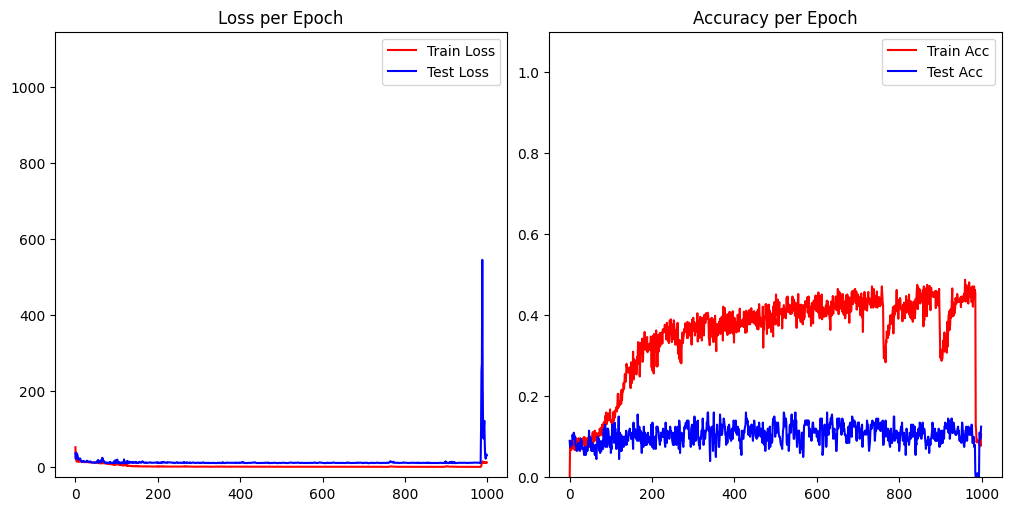

In [30]:
model = PitchClassifier(hyperparameters['filters']) # .to(device)
print_model(model)

results = demo(model, mnistspec, hyperparameters['n_epochs'], verbose=True)
plot(results)



In [ ]:
model = PitchClassifier() # .to(device)

# print()

# print_model(model)
# results = demo(model, mnist, 100, verbose=True)
# plot(results)

# configuration = {
#     "model": model,
#     "trainloader": mini_dataloader_train,
#     "testloader": mini_dataloader_test,
#     "epochs": 60,
#     "learning_rate": 1e-3,
#     "milestones": [40, 50],
#     "weight_decay": 1e-5
# }

# optimlr = 0.001
# optimwd = 0.01
# acctyp = ['<class \'numpy.float64\'>', 'float32', 'float16', 'complex64', 'complex128', 'int64', 'int32', 'int16', 'int8', 'uint8', 'bool']

# # for lab in labels_mini:
# #     for num in lab:
# #         if str(type(num)) not in acctyp:
# #             print(num)
# #             print(type(num))
# # print(type(labels_mini))

# min_lab = torch.from_numpy(labels_mini)

# # optimizer = torch.optim.Adam(model.parameters(), lr=optimlr, weight_decay=optimwd)
# optimizer = torch.optim.Adam(model.parameters(), lr=optimlr, weight_decay=optimwd)
# run_one_epoch(model, optimizer, mini_dataset.notes, y_train)